#### **Modeling_&_Evaluation**
#### Project name: **Telecom Customer Churn Prediction**
#### Author: **Fausto Pucheta Fortin**

#### **Introduction:** 
This notebook is the continuation of Feature_Engineer. \
Previously, key techniques such as binning, normalization, standardization, and feature selection were performed. Now, we're all set for splitting the data and experimenting with 3 specifics algorithms: Decistion Tree Classifier, Random Forest Classifier, and XGBoost. Each of which, will be tested applying different hyper parameters and cross-validation techniques. \
Later, the best algorithm will be selected based on best performance, and it will be evaluated using metrics as: \
- *Precision*
- *Recall*
- *ROC AUC*
This metrics will be visualized through:
1. *Precision-Recall Curve*: It will asses how well the model minimizes *false positives*.
2. *ROC Curve and ROC AUC*: It will provide a visualization of the model's ability to distinguish between *positive and negative classes* across various thresholds. \
Finally, the model's features importance will be examined in order to understand which have the most influence on the model's predictions, and thus, what drives customers to churn giving valuable information for decision-making for customer retention.


#### **Tasks:**
1. Data Splitting

2. Save Training, Validation, and Test data

3. Modeling and Evaluation (Choosing the best model):
    1. Choosing between Decision Tree Classifier, Random Forest, and XGBoost: \
    Selecting the best model using *randomized search*, *cross-validation* and *hyperparameter tuning*.
    2. Print best model's parameters.
    3. Print Confusion Matrix Classification Report of the best algorithm.
    4. Visualizing Metrics:
        1. *Precision-Recall Curve*.
        2. *ROC AUC Curve*.

4. Feature Importance Analysis  
    
#### **Findings:**


#### **Further steps:**


In [4]:
import sys
sys.path.append('../src/functions')


# EDA functions
from plot_functions import *

# Analysis libraries
import numpy as np
import pandas as pd
import pickle

# Visualization libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Plot Functions
from plot_functions import *

# Data Splitting and Modeling
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc, roc_auc_score, roc_curve, make_scorer, precision_recall_curve
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
import joblib
from modeling import *


# Import data frame
#df = pd.read_pickle("../data/processed/modeling_df.pkl")


1. Data Splitting

In [14]:
X = df.drop('Churn', axis=1)  # Features
y = df['Churn']  # Target variable

# Validation set
X_train, X_remaining, y_train, y_remaining = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Splitting the remaining data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_remaining, y_remaining, test_size=0.5, random_state=42)

In [15]:
print("Training set distribution:")
print(y_train.value_counts())

print("Validation set distribution:")
print(y_val.value_counts())

print("Testing set distribution:")
print(y_test.value_counts())

Training set distribution:
Churn
1.0    196344
0.0    157300
Name: count, dtype: int64
Validation set distribution:
Churn
1.0    42218
0.0    33563
Name: count, dtype: int64
Testing set distribution:
Churn
1.0    41930
0.0    33851
Name: count, dtype: int64


2. Save Training, Test, and Validation data

In [16]:
# Save the training data
with open('../data/processed/train_df/X_train.pkl', 'wb') as file:
    pickle.dump(X_train, file)

with open('../data/processed/train_df/y_train.pkl', 'wb') as file:
    pickle.dump(y_train, file)

# Saving the validation data
with open('../data/processed/validation_df/X_val', 'wb') as file:
    pickle.dump(X_val, file)
    
with open('../data/processed/validation_df/y_val', 'wb') as file:
    pickle.dump(y_val, file)
    
# Save the testing data
with open('../data/processed/test_df/X_test.pkl', 'wb') as file:
    pickle.dump(X_test, file)

with open('../data/processed/test_df/y_test.pkl', 'wb') as file:
    pickle.dump(y_test, file)

In [12]:
X_train, y_train, X_test, y_test = (pd.read_pickle("../data/processed/train_df/X_train.pkl"),
                                    pd.read_pickle("../data/processed/train_df/y_train.pkl"),
                                    pd.read_pickle("../data/processed/test_df/X_test.pkl"),
                                    pd.read_pickle("../data/processed/test_df/y_test.pkl"),
                                    )

3. Modeling (Choosing the best model)

3. 1. Choosing between Decision Tree Classifier, Random Forest, and XGBoost: \
    Selecting the best model using *randomized search*, *cross-validation* and *hyperparameter tuning*.

In [3]:
param_grid = {
    "Decision Tree Classifier": {
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
    },
    "Random Forest": {
        "n_estimators": [50, 100, 150],
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
    },
    "XGBoost": {
        "n_estimators": [50, 100, 150],
        "max_depth": [3, 4, 5],
        "learning_rate": [0.01, 0.1, 0.2],
        "min_child_weight": [1, 2],
        "subsample": [0.8, 0.9]
    },
}
models = {
    "Decision Tree Classifier": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": xgb.XGBClassifier()
}

model_list = []
accuracy_list = []
f1_list = []
recall_list = []
roc_auc_list = []

best_model = None
best_mean_accuracy = 0.0

for model_name, model in models.items():
    # Hyperparameter tuning using RandomizedSearchCV
    if model_name in param_grid:
        param_dist = param_grid[model_name]
        random_search = RandomizedSearchCV(
            model, param_distributions=param_dist, n_iter=10, cv=5, n_jobs=-1, random_state=42, scoring=make_scorer(accuracy_score)
        )
        random_search.fit(X_train, y_train)
        best_estimator = random_search.best_estimator_
    else:
        best_estimator = model
    
    # Cross-validation
    scores = cross_val_score(best_estimator, X_train, y_train, cv=5, scoring="accuracy")
    mean_accuracy = scores.mean()
    
    # Check if this model has the best mean accuracy so far
    if mean_accuracy > best_mean_accuracy:
        best_mean_accuracy = mean_accuracy
        best_model = best_estimator
    
    # Train the best model
    best_estimator.fit(X_train, y_train)

# Now you have the best model based on mean accuracy
if best_model is not None:
    # Make predictions
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    
    # Evaluate Train and Test sets
    # Train set
    accuracy_train, precision_score_train, recall_train, roc_auc_train = evaluate_model(y_train, y_train_pred)
    
    # Test set
    accuracy_test, precision_score_test, recall_test, roc_auc_test = evaluate_model(y_test, y_test_pred)
    
    # Best model name
    best_model_name = best_model.__class__.__name__
    
    # Save the best model to a file
    best_model_filename = f"../Models/{best_model_name}.pkl"
    joblib.dump(best_model, best_model_filename)


    # Print results for the best model
    print("Best Model: {}".format(best_model_name))
    print("Mean Cross-Validation Accuracy: {:.4f}".format(best_mean_accuracy))
    
    print("Model performance for Training set")
    print("- Accuracy Score: {:.4f}".format(accuracy_train))
    print("- Precision Score: {:.4f}".format(precision_score_train))
    print("- Recall Score: {:.4f}".format(recall_train))
    print("- ROC & AUC Score: {:.4f}".format(roc_auc_train))
    
    print("-" * 35)
    
    print("Model performance for Test set")
    print("- Accuracy Score: {:.4f}".format(accuracy_test))
    print("- Precision Score: {:.4f}".format(precision_score_test))
    print("- Recall Score: {:.4f}".format(recall_test))
    print("- ROC & AUC Score: {:.4f}".format(roc_auc_test))

c:\Users\Fausto\Telecom-Customer-Churn-Prediction\churnvenv\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\Fausto\Telecom-Customer-Churn-Prediction\churnvenv\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\Fausto\Telecom-Customer-Churn-Prediction\churnvenv\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\Fausto\Telecom-Customer-Churn-Prediction\churnvenv\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed 

Best Model: RandomForestClassifier
Mean Cross-Validation Accuracy: 0.9208
Model performance for Training set
- Accuracy Score: 0.9260
- Precision Score: 0.8974
- Recall Score: 0.9787
- ROC & AUC Score: 0.9195
-----------------------------------
Model performance for Test set
- Accuracy Score: 0.9211
- Precision Score: 0.8935
- Recall Score: 0.9733
- ROC & AUC Score: 0.9148


3. 2. Print best model's parameters

In [11]:
clf = joblib.load("../Models/RandomForestClassifier.pkl")
model_params = clf.get_params()

# Print the parameters
best_model_params = {param:value for param, value in model_params.items()}
best_model_params

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 20,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 150,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

3. 3. Print Confusion Matrix Classification Report of the best algorithm.

In [5]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_test_pred, target_names=['No Churn', 'Churn']))
print(metrics.confusion_matrix(y_test, y_test_pred))

              precision    recall  f1-score   support

    No Churn       0.96      0.86      0.91     33851
       Churn       0.89      0.97      0.93     41930

    accuracy                           0.92     75781
   macro avg       0.93      0.91      0.92     75781
weighted avg       0.92      0.92      0.92     75781

[[28988  4863]
 [ 1119 40811]]


3. 4. Visualizing Metrics:

3. 4. 1. Precision-Recall Curve

Saved at ../reports/figures/Modeling_&_Evaluation/


<module 'matplotlib.pyplot' from 'c:\\Users\\Fausto\\Telecom-Customer-Churn-Prediction\\churnvenv\\lib\\site-packages\\matplotlib\\pyplot.py'>

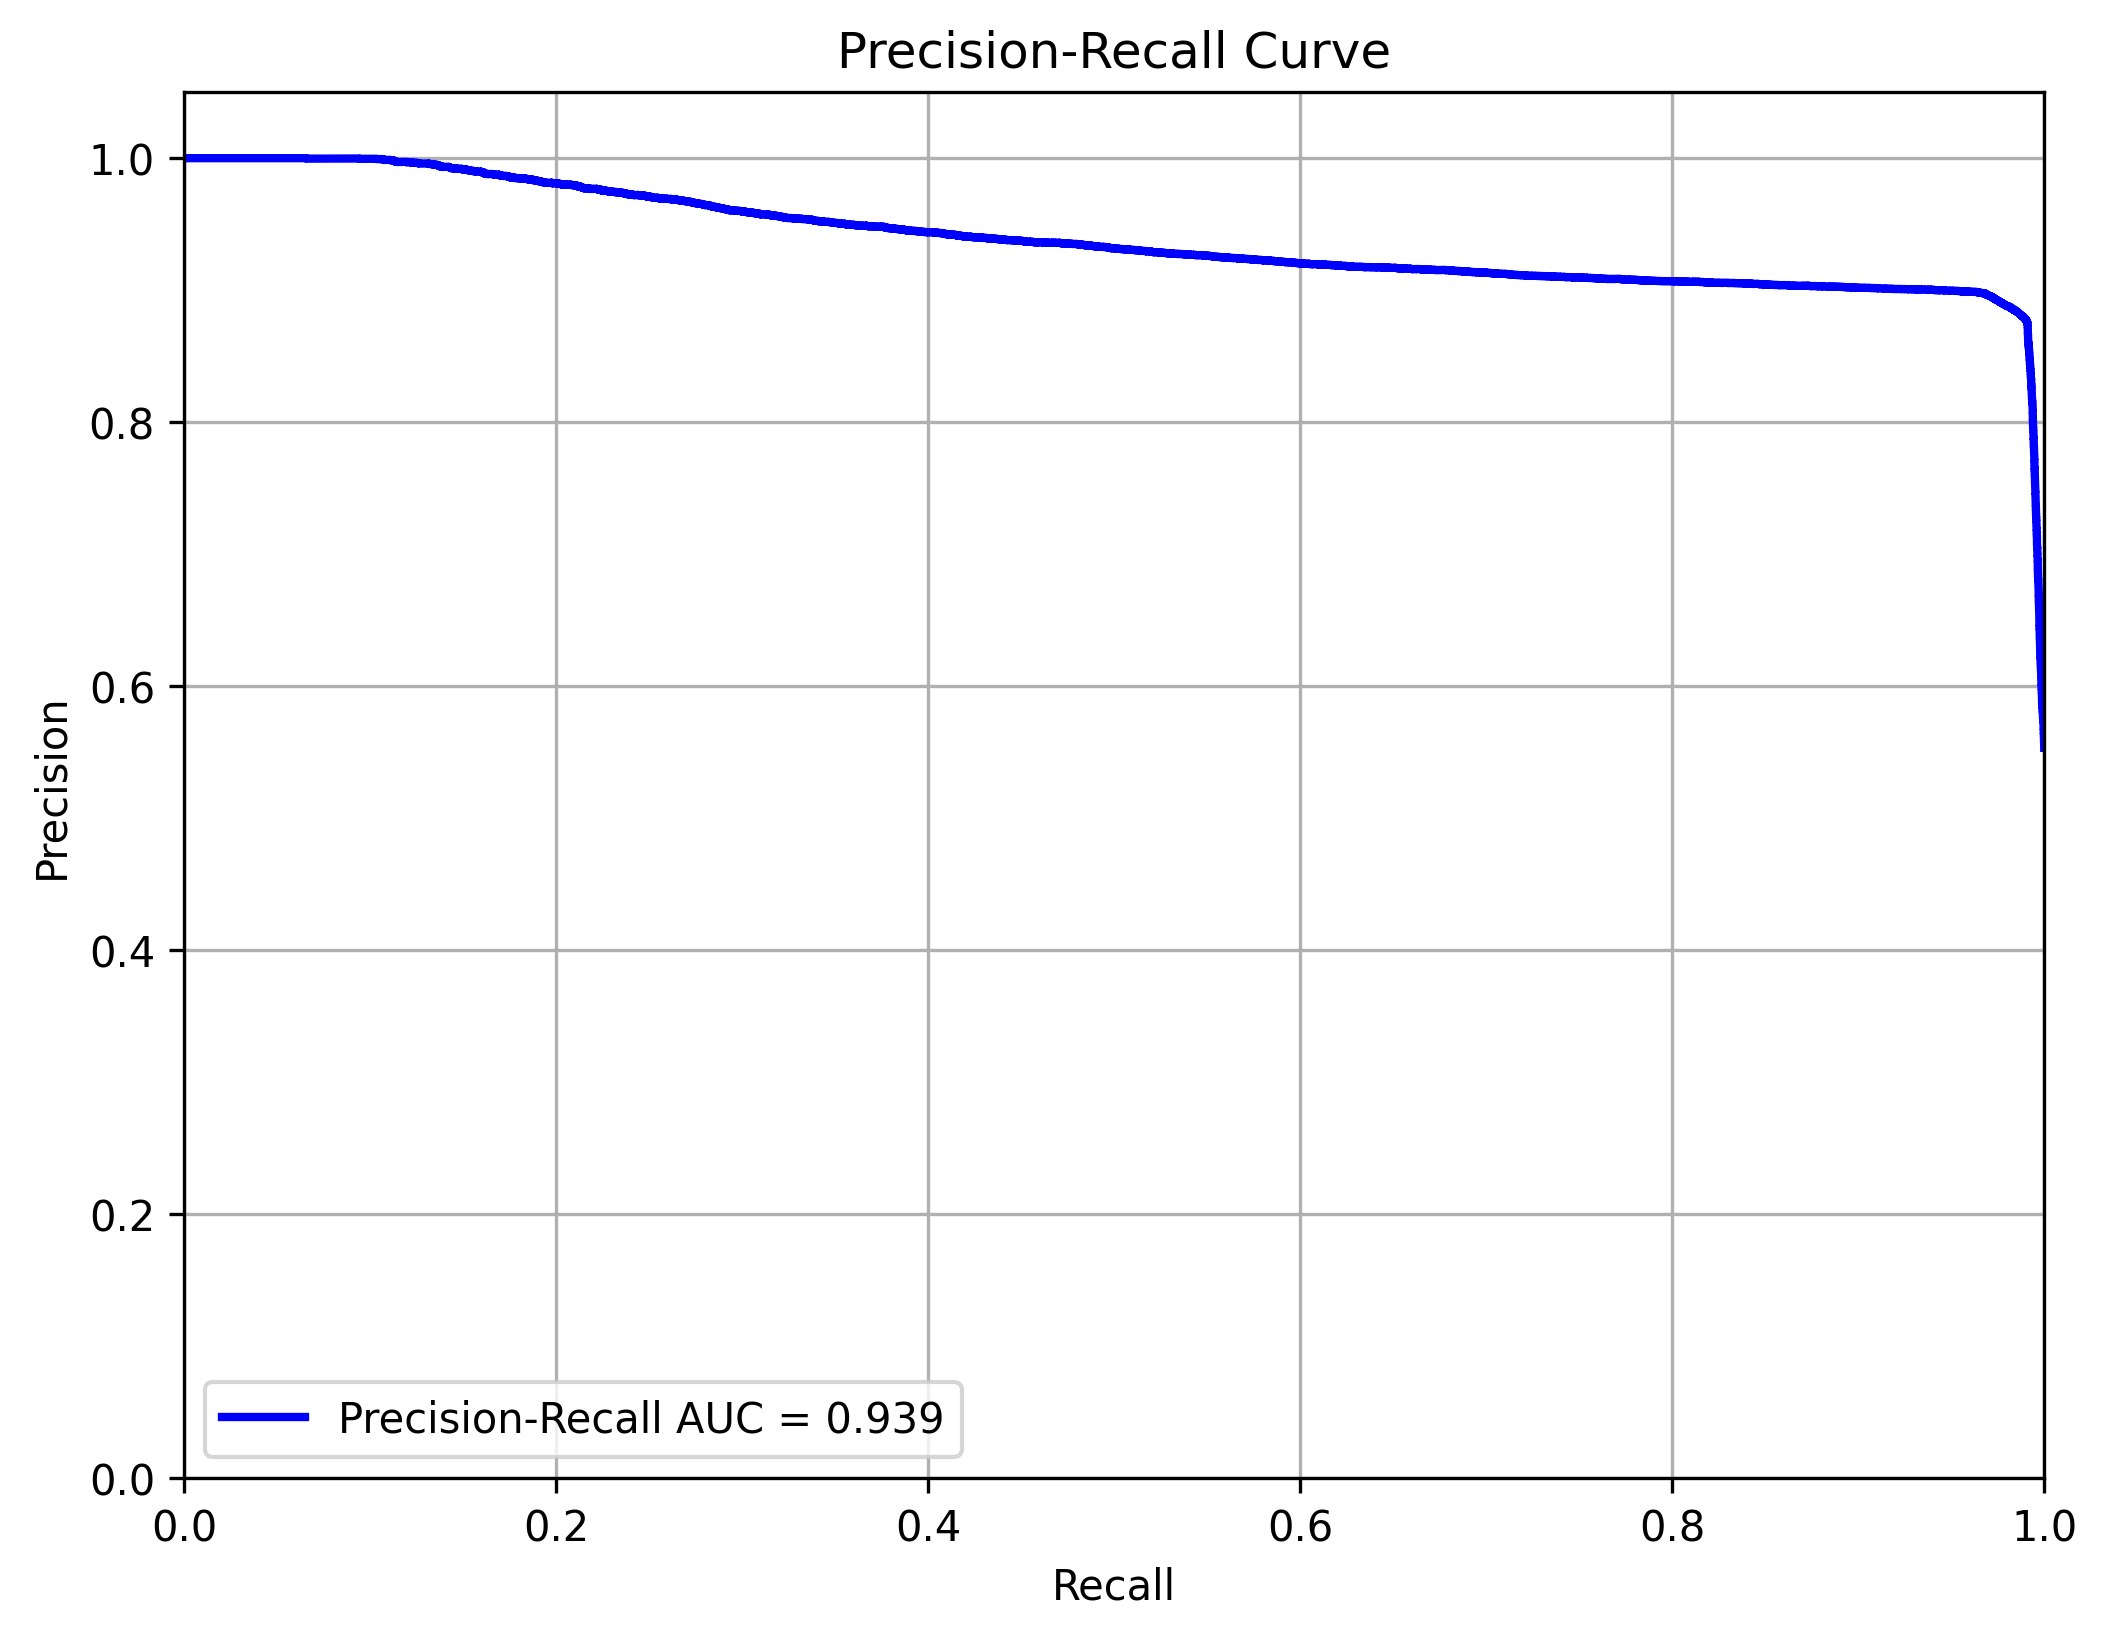

In [13]:
# Precision-Recall Curve

y_true = y_test
y_scores = clf.predict_proba(X_test)[:, 1]

def plot_precision_recall_curve(y_true, y_scores, save_path=None):
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

    # Calculate Precision-Recall AUC
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='b', lw=2, label=f'Precision-Recall AUC = {pr_auc:.3f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve')
    plt.grid()
    plt.legend(loc='lower left')
    
    # Save figure
    if save_path:
        os.makedirs(save_path, exist_ok=True)
        precision_recall_curve_save_path = os.path.join(save_path, "precision_recall_curve.png")
        plt.savefig(precision_recall_curve_save_path, bbox_inches='tight', dpi=300)
    print(f"Saved at {save_path}")

    return plt


plot_precision_recall_curve(y_true, y_scores, "../reports/figures/Modeling_&_Evaluation/")

3. 4. 2. ROC AUC Curve

Saved at ../reports/figures/Modeling_&_Evaluation/


<module 'matplotlib.pyplot' from 'c:\\Users\\Fausto\\Telecom-Customer-Churn-Prediction\\churnvenv\\lib\\site-packages\\matplotlib\\pyplot.py'>

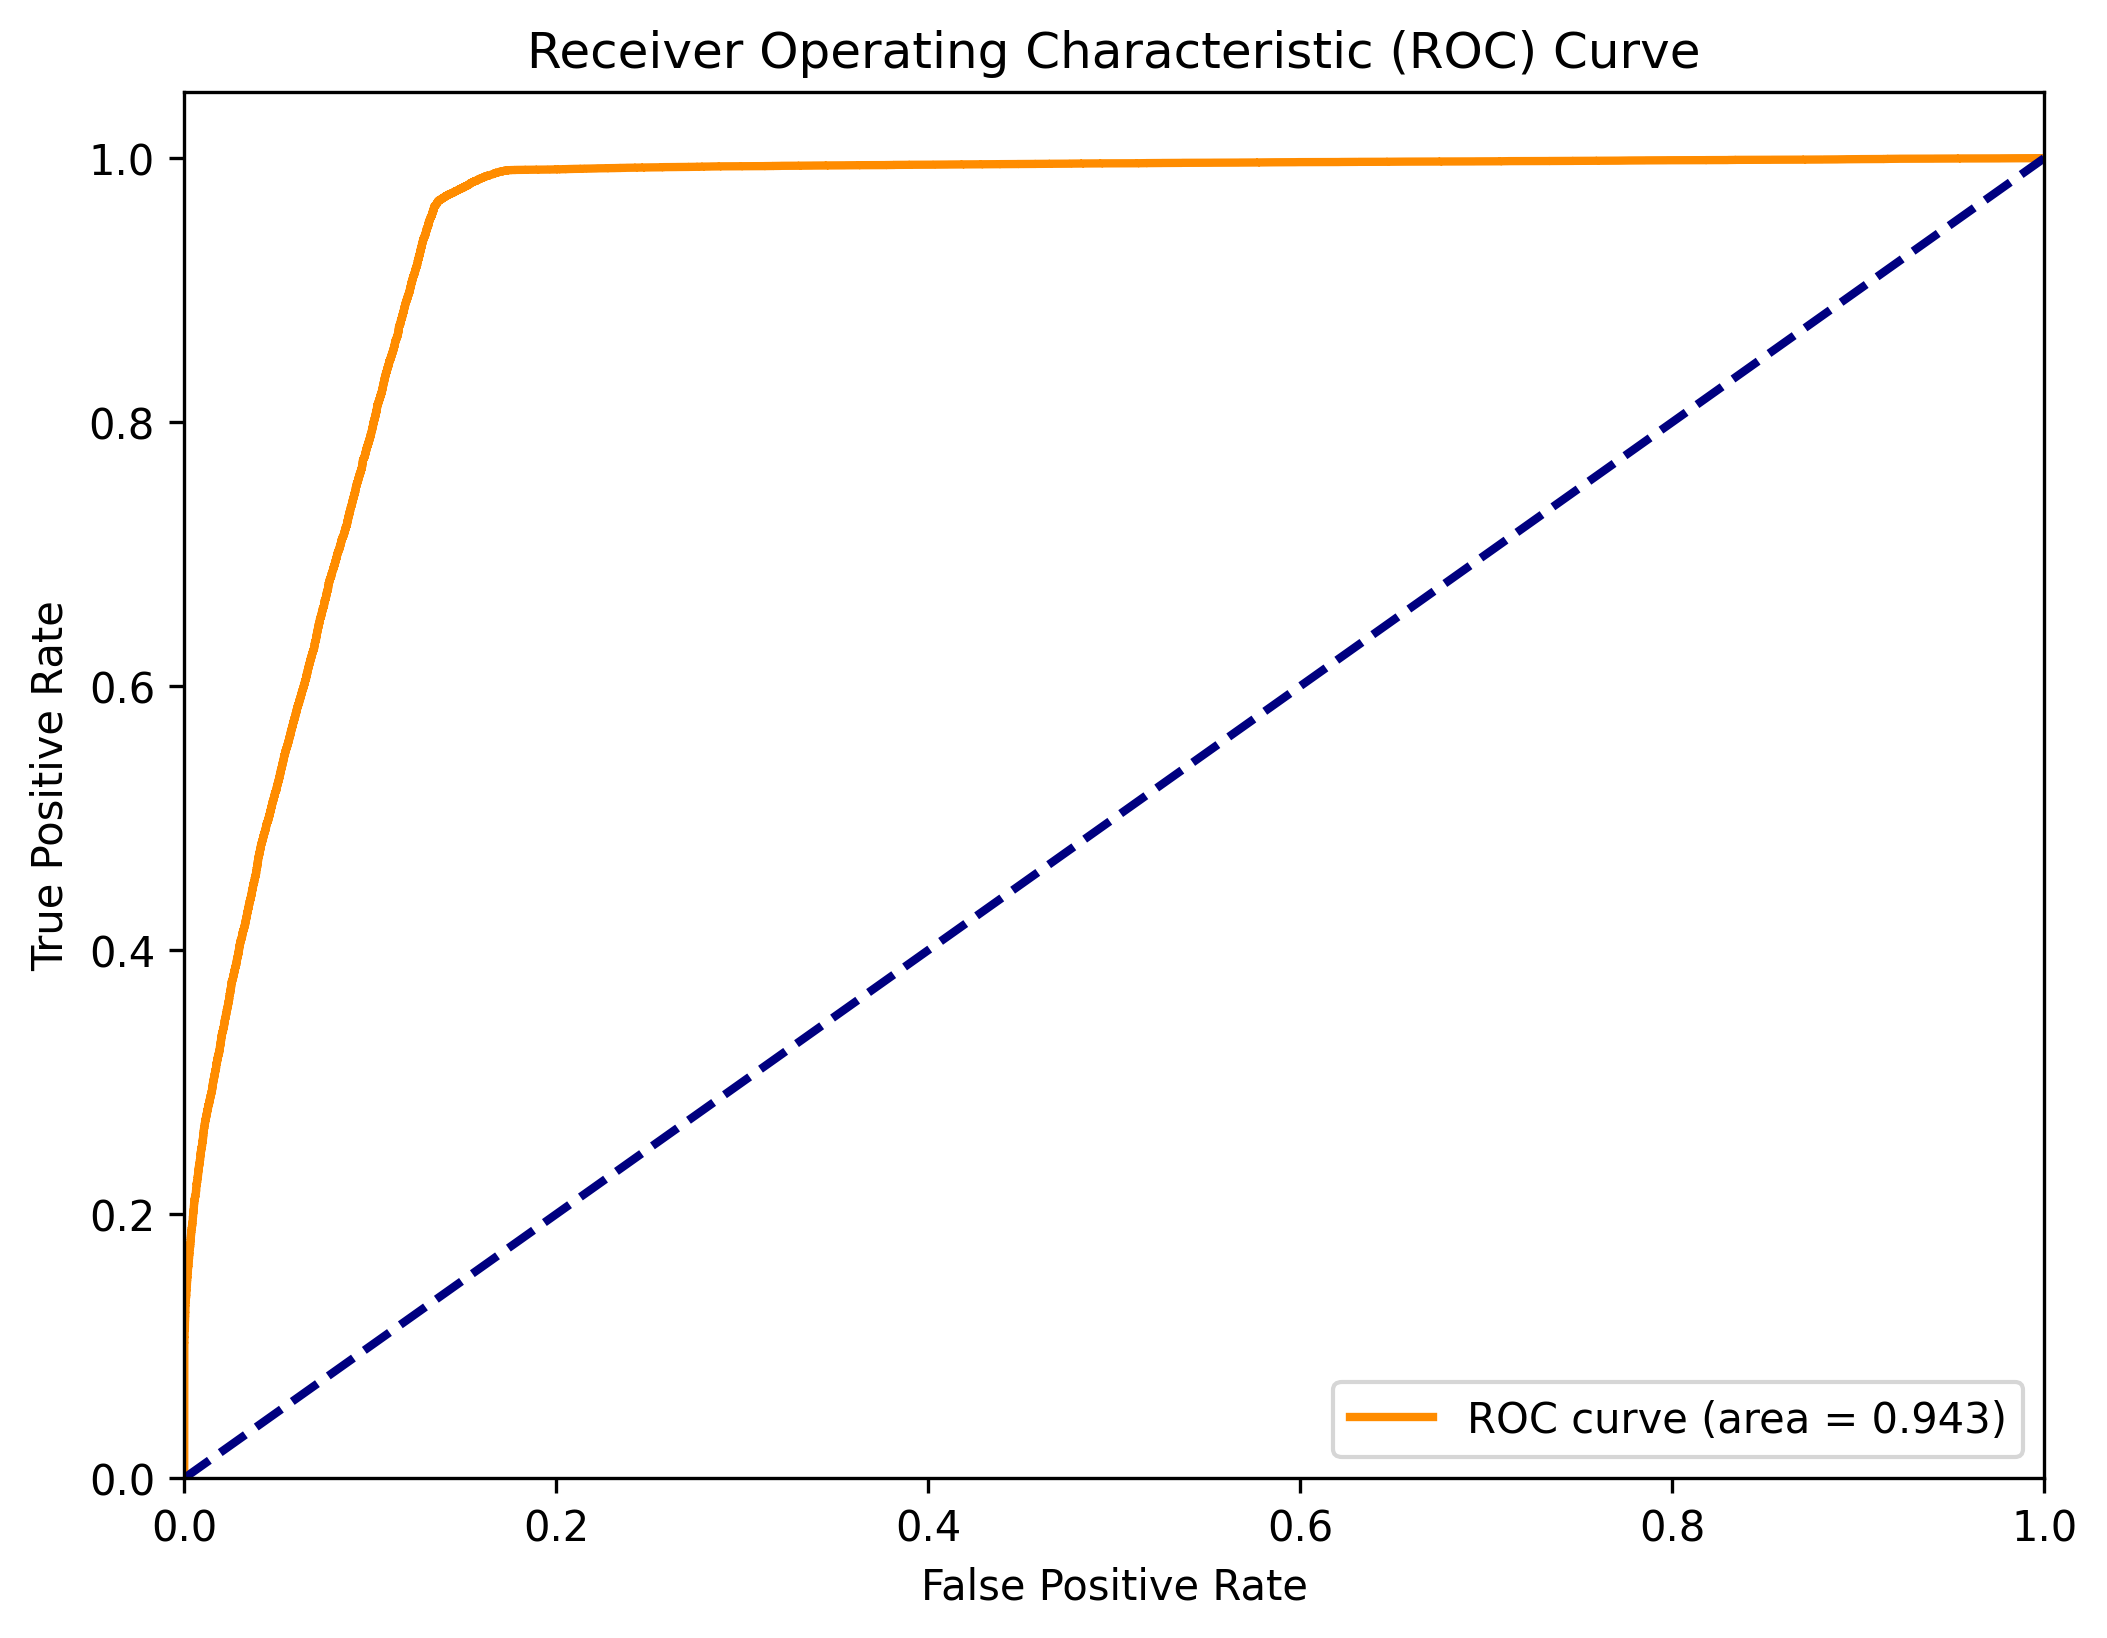

In [14]:
def plot_roc_auc_curve(y_true, y_scores, save_path=None):
    # ROC AUC Curve
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)

    # Calculate ROC AUC
    roc_auc = roc_auc_score(y_true, y_scores)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.3f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    
    # Save the plot
    if save_path:
        # Create the directory if it doesn't exist
        os.makedirs(save_path, exist_ok=True)  
        roc_auc_curve_save_path = os.path.join(save_path, "roc_auc_curve.png")
        plt.savefig(roc_auc_curve_save_path, bbox_inches='tight', dpi=300)
    print(f"Saved at {save_path}")
    
    return plt

plot_roc_auc_curve(y_true, y_scores, "../reports/figures/Modeling_&_Evaluation/")

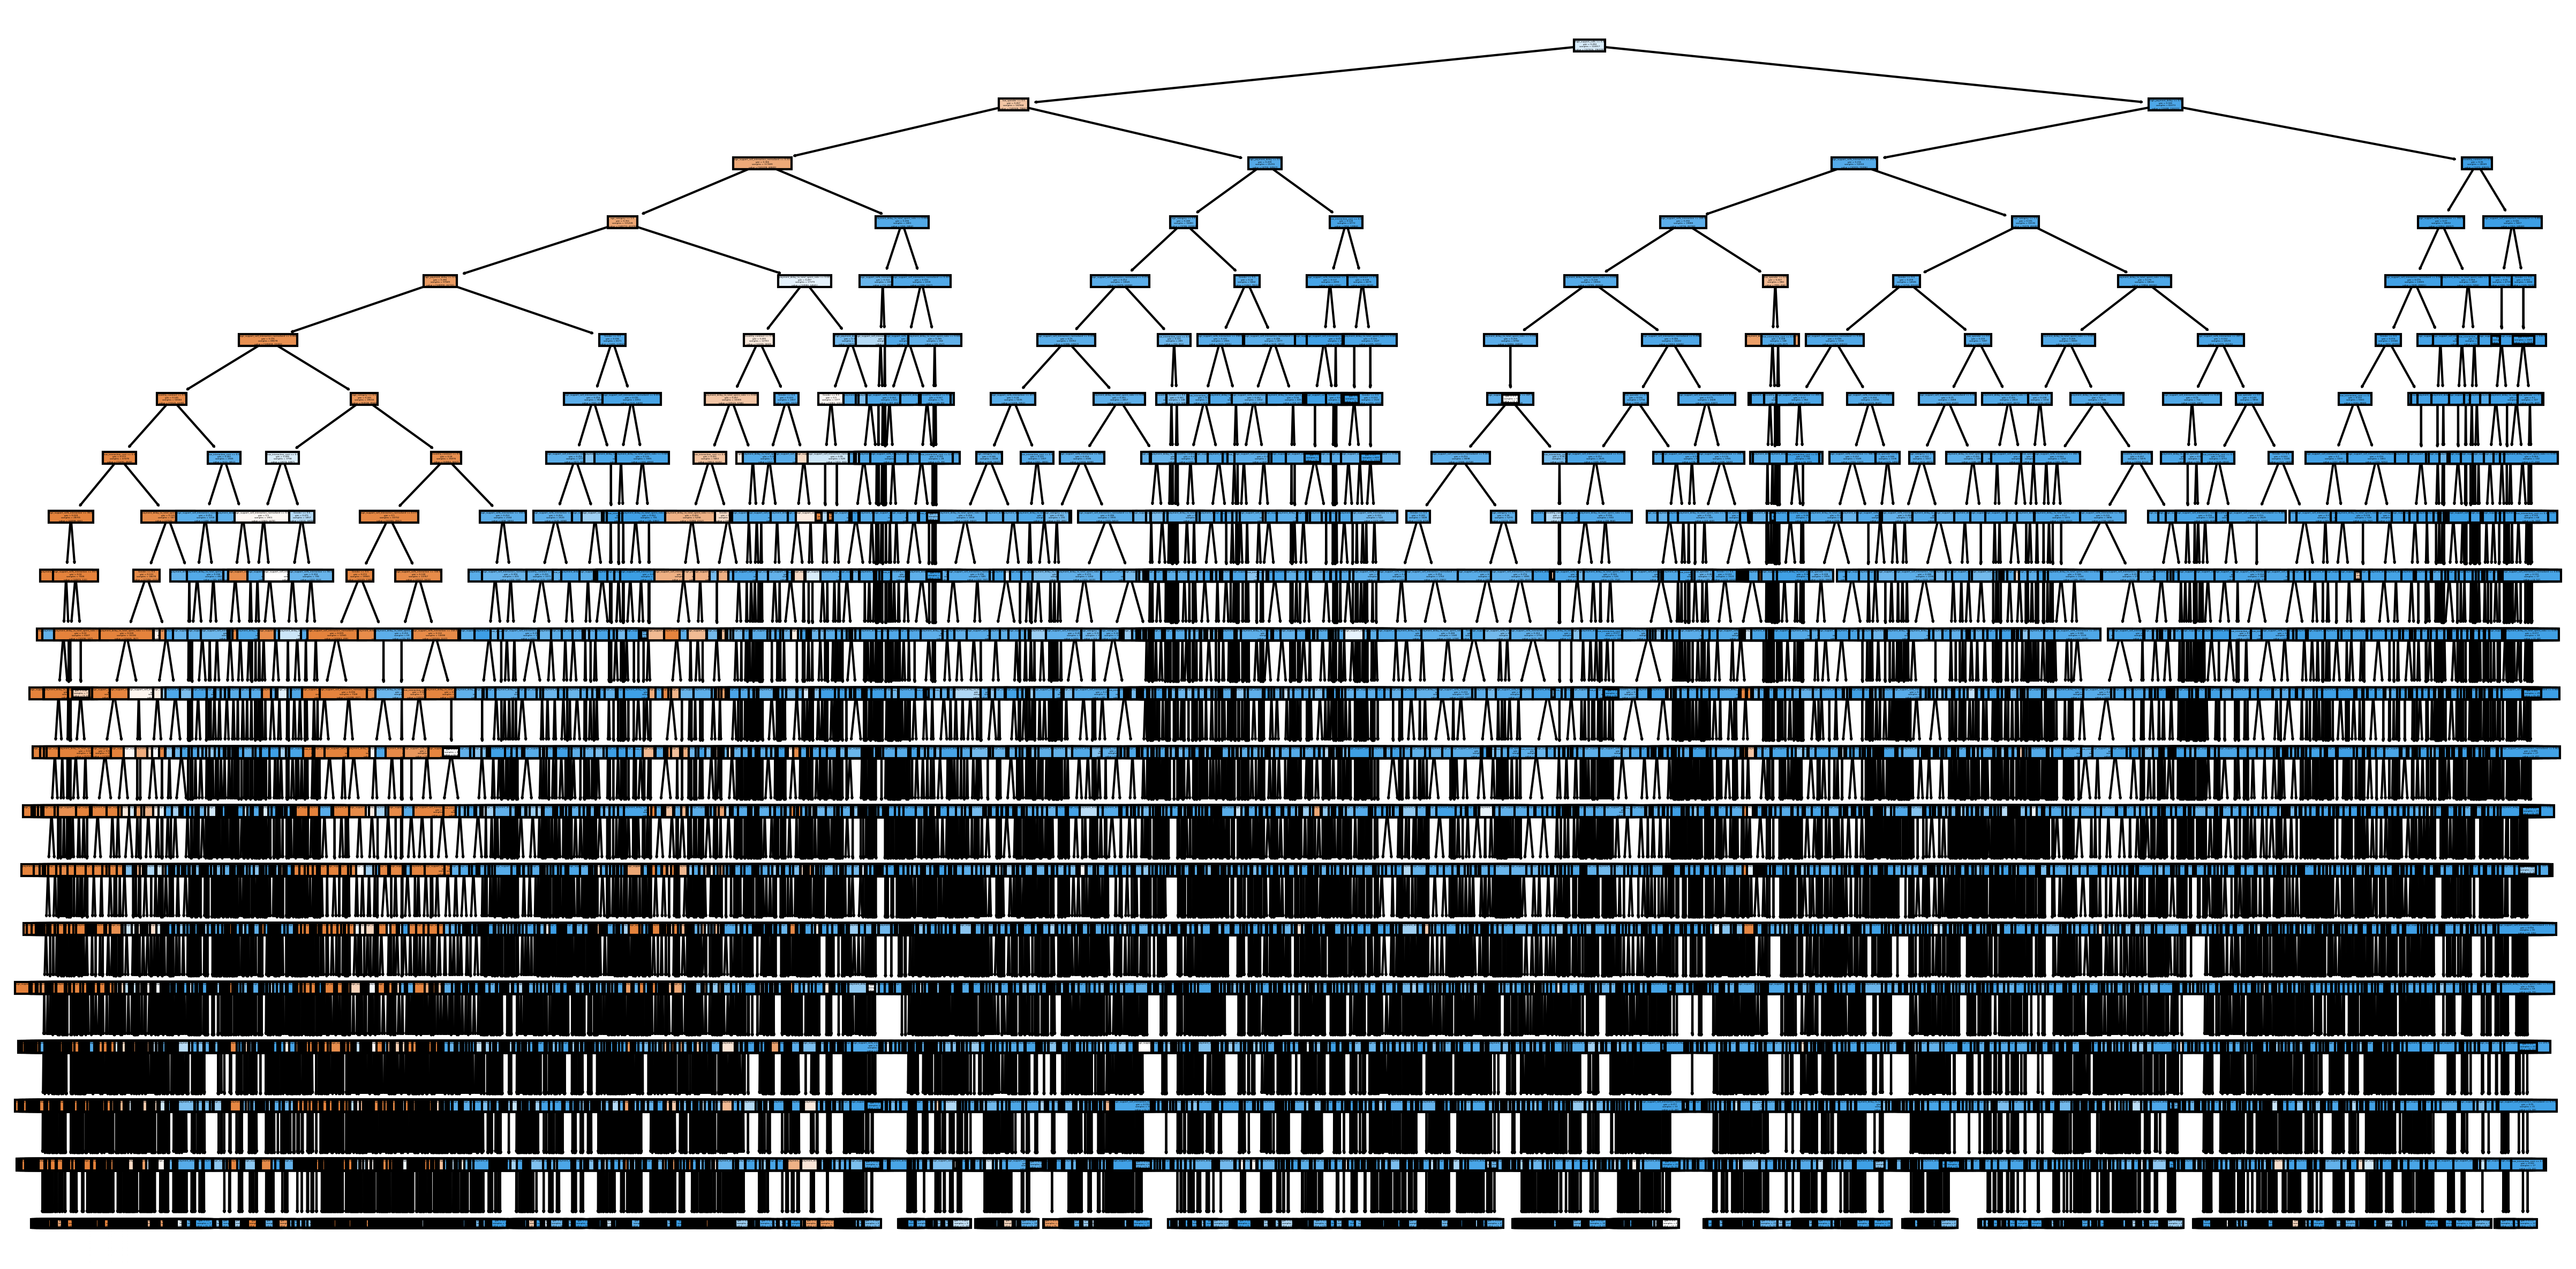

In [56]:
from sklearn.tree import plot_tree

# Extracting the first tree (index 0)
tree = best_model.estimators_[0]

# Visualizing the tree
plt.figure(figsize=(20, 10))  # Adjust the figure size as needed
plot_tree(tree, filled=True, feature_names=X_train.columns)
plt.show()

5. 1. Feature Importance Score

Saved at ../reports/figures/Modeling_&_Evaluation/


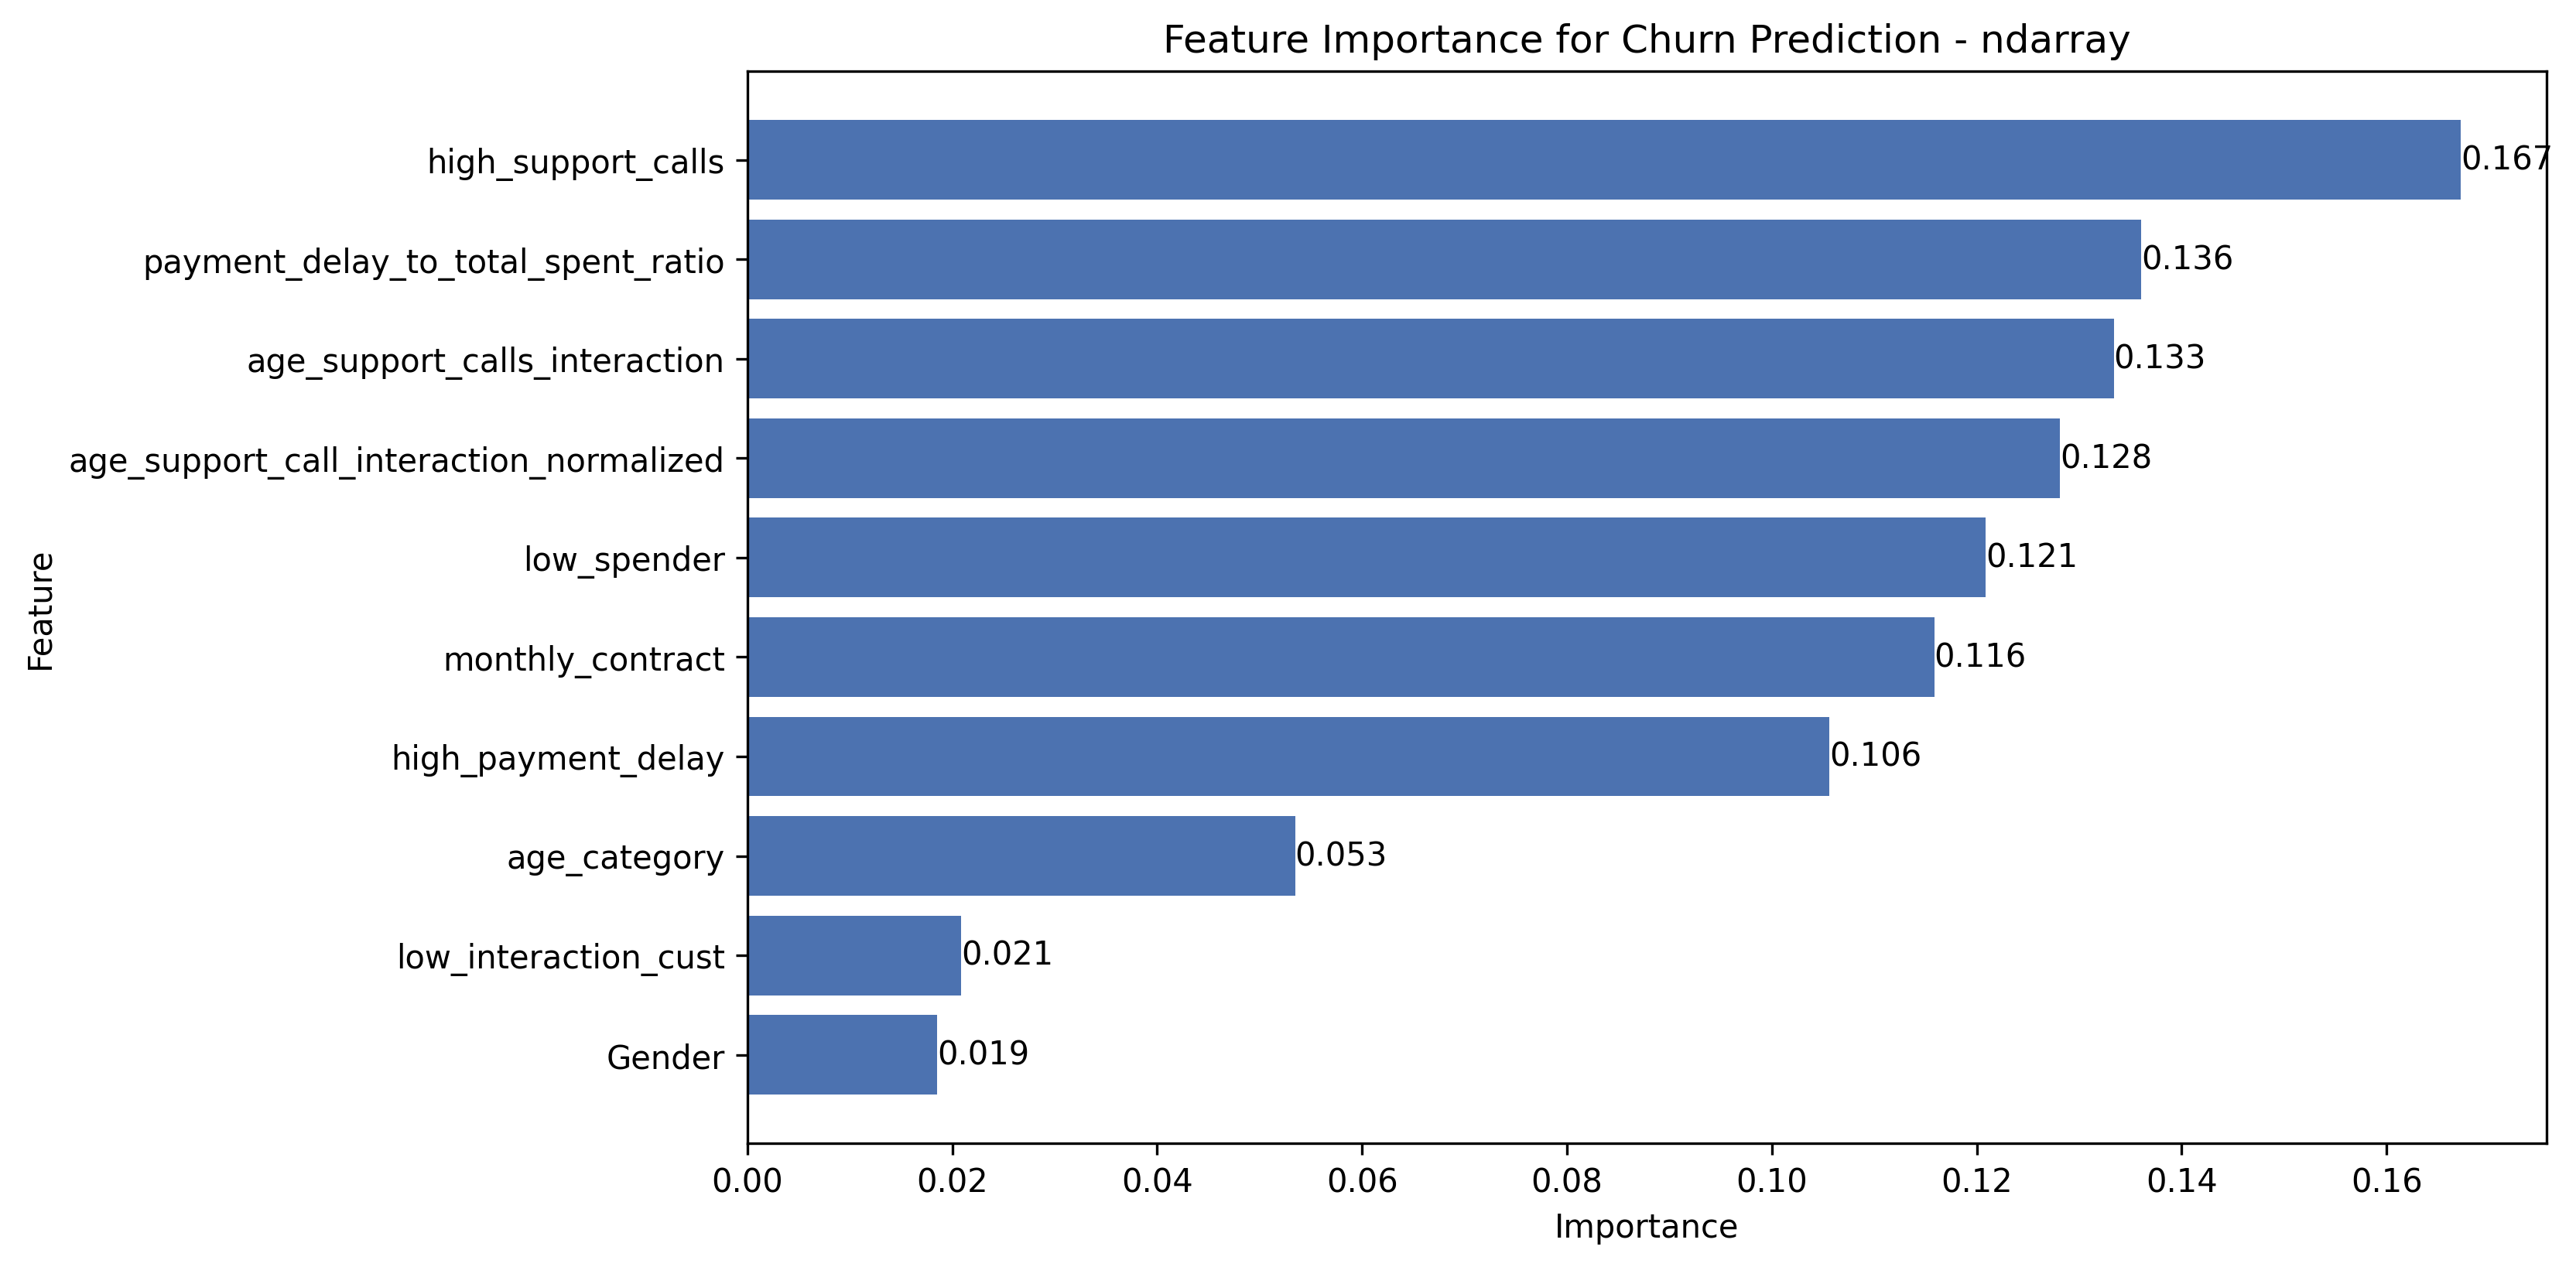

<module 'matplotlib.pyplot' from 'c:\\Users\\Fausto\\Telecom-Customer-Churn-Prediction\\churnvenv\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [21]:
feature_names = X_train.columns
clf_feature_importance = clf.feature_importances_

def plot_feature_importances(clf_feature_importance, feature_names, save_path=None):
    # Name of the classifier
    clf_name = clf_feature_importance.__class__.__name__
    
    # Create a DataFrame to store feature names and importances
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': clf_feature_importance})

    # Sort the DataFrame by importance in descending order
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Create a bar plot to visualize feature importances
    plt.figure(figsize=(10, 6))
    bars = plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(f'Feature Importance for Churn Prediction - {clf_name}')
    plt.gca().invert_yaxis()  # Invert the y-axis for better readability
    
    # Add labels to the bars
    for bar in bars:
        width = bar.get_width()
        plt.text(width, bar.get_y() + bar.get_height()/2, f'{width:.3f}', ha='left', va='center')
        
        
    # Save plot
    if save_path:
        os.makedirs(save_path, exist_ok=True)
        feature_importance_plot_save_path = os.path.join(save_path, "feature_importance.png")
        plt.savefig(feature_importance_plot_save_path, bbox_inches="tight", dpi=300)
    print(f"Saved at {save_path}")

    plt.show()
    return plt

plot_feature_importances(clf_feature_importance, feature_names, "../reports/figures/Modeling_&_Evaluation/")